In [ ]:
!pip install fbprophet

  Using cached fbprophet-0.7.1.tar.gz (64 kB)
  Preparing metadata (setup.py) ... done
  Using cached cmdstanpy-0.9.5-py3-none-any.whl.metadata (2.9 kB)
  Using cached pystan-3.10.0-py3-none-any.whl.metadata (3.7 kB)
  Using cached LunarCalendar-0.0.9-py2.py3-none-any.whl.metadata (6.3 kB)
  Using cached convertdate-2.4.0-py3-none-any.whl.metadata (8.3 kB)
  Using cached setuptools_git-1.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached PyMeeus-0.5.12-py3-none-any.whl
  Using cached ephem-4.1.5-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.0 kB)
  Using cached clikit-0.6.2-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached httpstan-4.13.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (6.2 kB)
  Using cached pysimdjson-6.0.2-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.9 kB)
  Using cached crashtest-0.3.1-py3-none-any.whl.metadata (748 bytes)
  Using cached pastel-0.2.1-py2.py3-none-any.whl.metadata (1.9 k

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
# from fbprophet import Prophet
# import streamlit as st


In [ ]:
# Load data
trans_data1 = pd.read_csv('Transactional_data_retail_01.csv')
trans_data2 = pd.read_csv('Transactional_data_retail_02.csv')
customer_data = pd.read_csv('CustomerDemographics.csv')
product_info = pd.read_csv('ProductInfo.csv')

# Merge transaction files
trans_data = pd.concat([trans_data1, trans_data2], ignore_index=True)


In [ ]:
trans_data.describe()

,Quantity,Price,Customer ID
count,1.067371e+06,1.067371e+06,824364.000000
mean,9.938898e+00,4.649388e+00,15324.638504
std,1.727058e+02,1.235531e+02,1697.464450
min,-8.099500e+04,-5.359436e+04,12346.000000
25%,1.000000e+00,1.250000e+00,13975.000000
50%,3.000000e+00,2.100000e+00,15255.000000
75%,1.000000e+01,4.150000e+00,16797.000000
max,8.099500e+04,3.897000e+04,18287.000000


In [ ]:
print(trans_data.head())
print(customer_data.head())
print(product_info.head())

print(trans_data.info())
print(customer_data.info())
print(product_info.info())



  Invoice StockCode  Quantity  Price  Customer ID       InvoiceDate
0  489434     85048        12   6.95      13085.0  01 December 2021
1  489434    79323P        12   6.75      13085.0  01 December 2021
2  489434    79323W        12   6.75      13085.0  01 December 2021
3  489434     22041        48   2.10      13085.0  01 December 2021
4  489434     21232        24   1.25      13085.0  01 December 2021
   Customer ID         Country
0        13085  United Kingdom
1        13078  United Kingdom
2        15362  United Kingdom
3        18102  United Kingdom
4        12682          France
  StockCode                          Description
0    85123A   WHITE HANGING HEART T-LIGHT HOLDER
1     71053                  WHITE METAL LANTERN
2    84406B       CREAM CUPID HEARTS COAT HANGER
3    84029G  KNITTED UNION FLAG HOT WATER BOTTLE
4    84029E       RED WOOLLY HOTTIE WHITE HEART.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 6 columns):


In [ ]:
def clean_date_format(date_str):
    try:
        return pd.to_datetime(date_str, format='%d %B %Y')
    except:
        return pd.to_datetime(date_str)

trans_data['InvoiceDate'] = trans_data['InvoiceDate'].apply(clean_date_format)


trans_data.dropna(subset=['Customer ID'], inplace=True)


<ipython-input-9-6bf8b5d9023a>:5: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(date_str)


In [ ]:
merged_data = pd.merge(trans_data, customer_data, on='Customer ID', how='left')
merged_data = pd.merge(merged_data, product_info, on='StockCode', how='left')
merged_data['TotalRevenue'] = merged_data['Quantity'] * merged_data['Price']
merged_data['Year'] = merged_data['InvoiceDate'].dt.year
merged_data['Month'] = merged_data['InvoiceDate'].dt.month
merged_data['Week'] = merged_data['InvoiceDate'].dt.isocalendar().week


In [ ]:
top_10_products = merged_data.groupby('StockCode')['Quantity'].sum().nlargest(10)
print(top_10_products)


StockCode
85123A    450325
85099B    375064
22197     308648
84879     238302
23084     216752
21181     195192
22423     187568
21212     180498
20713     176220
21915     144868
Name: Quantity, dtype: int64


In [ ]:
top_10_revenue_products = merged_data.groupby('StockCode')['TotalRevenue'].sum().nlargest(10)
print(top_10_revenue_products)


StockCode
22423     2157893.60
85123A    1214279.30
85099B     673761.44
23084      409102.40
21181      386704.80
84879      379062.54
22502      327537.90
20713      318362.76
47566      308058.69
20685      305943.25
Name: TotalRevenue, dtype: float64


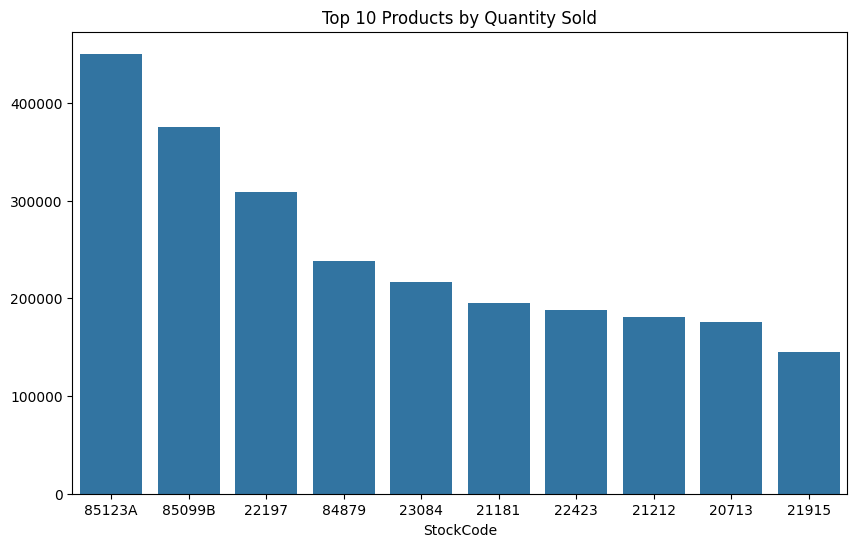

In [ ]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_products.index, y=top_10_products.values)
plt.title('Top 10 Products by Quantity Sold')
plt.show()


In [ ]:
time_series_data = merged_data[merged_data['StockCode'].isin(top_10_products.index)]
weekly_sales = time_series_data.groupby(['StockCode', 'Year', 'Week'])['Quantity'].sum().reset_index()


In [ ]:
import pickle
from statsmodels.tsa.arima.model import ARIMA

# Assuming weekly_sales and top_10_products are already defined

for product in top_10_products.index:
    # Get the product-specific sales data
    product_sales = weekly_sales[weekly_sales['StockCode'] == product].set_index('Week')['Quantity']

    # Create and fit the ARIMA model
    arima_model = ARIMA(product_sales, order=(1, 1, 1))
    arima_result = arima_model.fit()

    # Save the ARIMA model using pickle
    model_filename = f'arima_model_product_{product}.pkl'
    with open(model_filename, 'wb') as file:
        pickle.dump(arima_result, file)

    # Forecast future sales
    forecast = arima_result.forecast(steps=15)
    print(f'Forecast for Product {product}:')
    print(forecast)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

Forecast for Product 85123A:
104    4622.748714
105    4694.264566
106    4692.117640
107    4692.182091
108    4692.180156
109    4692.180214
110    4692.180213
111    4692.180213
112    4692.180213
113    4692.180213
114    4692.180213
115    4692.180213
116    4692.180213
117    4692.180213
118    4692.180213
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

Forecast for Product 85099B:
104    3507.118918
105    3572.180537
106    3577.177491
107    3577.561274
108    3577.590750
109    3577.593014
110    3577.593188
111    3577.593201
112    3577.593202
113    3577.593202
114    3577.593202
115    3577.593202
116    3577.593202
117    3577.593202
118    3577.593202
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

Forecast for Product 22197:
104    4597.503289
105    4672.892853
106    4675.366663
107    4675.447838
108    4675.450501
109    4675.450589
110    4675.450591
111    4675.450592
112    4675.450592
113    4675.450592
114    4675.450592
115    4675.450592
116    4675.450592
117    4675.450592
118    4675.450592
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

Forecast for Product 84879:
104    2233.341636
105    2265.638495
106    2270.437792
107    2271.150965
108    2271.256943
109    2271.272691
110    2271.275031
111    2271.275379
112    2271.275430
113    2271.275438
114    2271.275439
115    2271.275439
116    2271.275439
117    2271.275439
118    2271.275439
Name: predicted_mean, dtype: float64
Forecast for Product 23084:
32    15907.745630
33    12660.331043
34    13356.520546
35    13207.269562
36    13239.266390
37    13232.406824
38    13233.877396
39    13233.562131
40    13233.629718
41    13233.615229
42    13233.618335
43    13233.617669
44    13233.617812
45    13233.617781
46    13233.617788
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

Forecast for Product 21181:
87     2200.294970
88     2221.835628
89     2223.123461
90     2223.200456
91     2223.205059
92     2223.205334
93     2223.205351
94     2223.205352
95     2223.205352
96     2223.205352
97     2223.205352
98     2223.205352
99     2223.205352
100    2223.205352
101    2223.205352
Name: predicted_mean, dtype: float64
Forecast for Product 22423:
92     1711.056939
93     1786.674105
94     1781.138509
95     1781.543745
96     1781.514080
97     1781.516251
98     1781.516093
99     1781.516104
100    1781.516103
101    1781.516103
102    1781.516103
103    1781.516103
104    1781.516103
105    1781.516103
106    1781.516103
Name: predicted_mean, dtype: float64
Forecast for Product 21212:
104    1020.360293
105    1247.272686
106    1221.051361
107    1224.081420
108    1223.731275
109    1223.771737
110    1223.767061
111    1223.767602
112    1223.767539
113    1223.767546
114    1223.767546
115    1223.767546
116    1223.767546
117    1223.767546
118   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

In [ ]:
for product in top_10_products.index:
    product_sales = weekly_sales[weekly_sales['StockCode'] == product].set_index('Week')['Quantity']
    arima_model = ARIMA(product_sales, order=(1, 1, 1))
    arima_result = arima_model.fit()
    forecast = arima_result.forecast(steps=15)
    print(f'Forecast for Product {product}:')
    print(forecast)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be give

Forecast for Product 85123A:
104    4622.748714
105    4694.264566
106    4692.117640
107    4692.182091
108    4692.180156
109    4692.180214
110    4692.180213
111    4692.180213
112    4692.180213
113    4692.180213
114    4692.180213
115    4692.180213
116    4692.180213
117    4692.180213
118    4692.180213
Name: predicted_mean, dtype: float64
Forecast for Product 85099B:
104    3507.118918
105    3572.180537
106    3577.177491
107    3577.561274
108    3577.590750
109    3577.593014
110    3577.593188
111    3577.593201
112    3577.593202
113    3577.593202
114    3577.593202
115    3577.593202
116    3577.593202
117    3577.593202
118    3577.593202
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

Forecast for Product 22197:
104    4597.503289
105    4672.892853
106    4675.366663
107    4675.447838
108    4675.450501
109    4675.450589
110    4675.450591
111    4675.450592
112    4675.450592
113    4675.450592
114    4675.450592
115    4675.450592
116    4675.450592
117    4675.450592
118    4675.450592
Name: predicted_mean, dtype: float64
Forecast for Product 84879:
104    2233.341636
105    2265.638495
106    2270.437792
107    2271.150965
108    2271.256943
109    2271.272691
110    2271.275031
111    2271.275379
112    2271.275430
113    2271.275438
114    2271.275439
115    2271.275439
116    2271.275439
117    2271.275439
118    2271.275439
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

Forecast for Product 23084:
32    15907.745630
33    12660.331043
34    13356.520546
35    13207.269562
36    13239.266390
37    13232.406824
38    13233.877396
39    13233.562131
40    13233.629718
41    13233.615229
42    13233.618335
43    13233.617669
44    13233.617812
45    13233.617781
46    13233.617788
Name: predicted_mean, dtype: float64
Forecast for Product 21181:
87     2200.294970
88     2221.835628
89     2223.123461
90     2223.200456
91     2223.205059
92     2223.205334
93     2223.205351
94     2223.205352
95     2223.205352
96     2223.205352
97     2223.205352
98     2223.205352
99     2223.205352
100    2223.205352
101    2223.205352
Name: predicted_mean, dtype: float64


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

Forecast for Product 22423:
92     1711.056939
93     1786.674105
94     1781.138509
95     1781.543745
96     1781.514080
97     1781.516251
98     1781.516093
99     1781.516104
100    1781.516103
101    1781.516103
102    1781.516103
103    1781.516103
104    1781.516103
105    1781.516103
106    1781.516103
Name: predicted_mean, dtype: float64
Forecast for Product 21212:
104    1020.360293
105    1247.272686
106    1221.051361
107    1224.081420
108    1223.731275
109    1223.771737
110    1223.767061
111    1223.767602
112    1223.767539
113    1223.767546
114    1223.767546
115    1223.767546
116    1223.767546
117    1223.767546
118    1223.767546
Name: predicted_mean, dtype: float64
Forecast for Product 20713:
96     1616.048328
97     1788.436322
98     1812.975079
99     1816.468075
100    1816.965289
101    1817.036066
102    1817.046141
103    1817.047575
104    1817.047779
105    1817.047808
106    1817.047812
107    1817.047813
108    1817.047813
109    1817.047813
110   

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the

In [ ]:
# prophet_data = weekly_sales.rename(columns={'Week': 'ds', 'Quantity': 'y'})
# for product in top_10_products.index:
#     product_data = prophet_data[prophet_data['StockCode'] == product]
#     model = Prophet()
#     model.fit(product_data)
#     future = model.make_future_dataframe(periods=15, freq='W')
#     forecast = model.predict(future)
#     model.plot(forecast)
#     plt.title(f'Prophet Forecast for Product {product}')
#     plt.show()


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast for Product Product A (Code: 85123A) for next 12 months:
104    4622.748714
105    4694.264566
106    4692.117640
107    4692.182091
108    4692.180156
109    4692.180214
110    4692.180213
111    4692.180213
112    4692.180213
113    4692.180213
114    4692.180213
115    4692.180213
Name: predicted_mean, dtype: float64
--------------------------------------------------


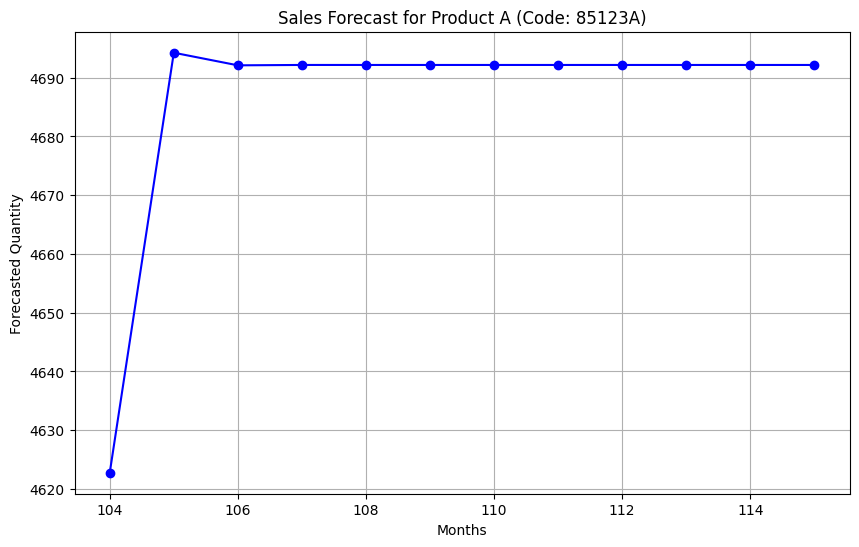

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast for Product Product B (Code: 85099B) for next 12 months:
104    3507.118918
105    3572.180537
106    3577.177491
107    3577.561274
108    3577.590750
109    3577.593014
110    3577.593188
111    3577.593201
112    3577.593202
113    3577.593202
114    3577.593202
115    3577.593202
Name: predicted_mean, dtype: float64
--------------------------------------------------


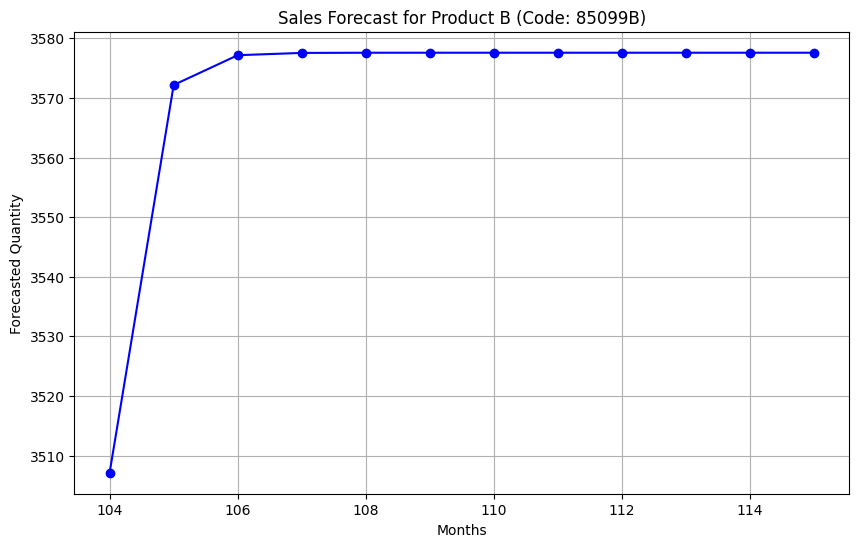

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast for Product Product C (Code: 22197) for next 12 months:
104    4597.503289
105    4672.892853
106    4675.366663
107    4675.447838
108    4675.450501
109    4675.450589
110    4675.450591
111    4675.450592
112    4675.450592
113    4675.450592
114    4675.450592
115    4675.450592
Name: predicted_mean, dtype: float64
--------------------------------------------------


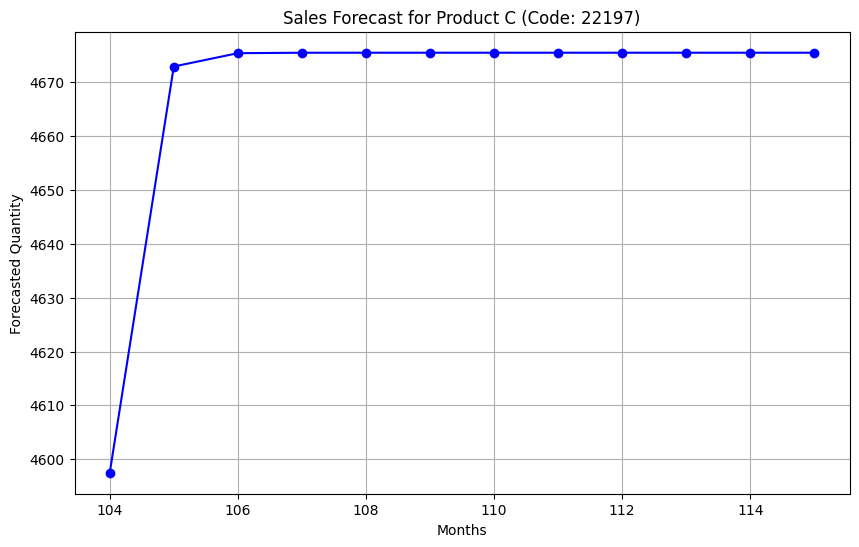

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast for Product Product D (Code: 84879) for next 12 months:
104    2233.341636
105    2265.638495
106    2270.437792
107    2271.150965
108    2271.256943
109    2271.272691
110    2271.275031
111    2271.275379
112    2271.275430
113    2271.275438
114    2271.275439
115    2271.275439
Name: predicted_mean, dtype: float64
--------------------------------------------------


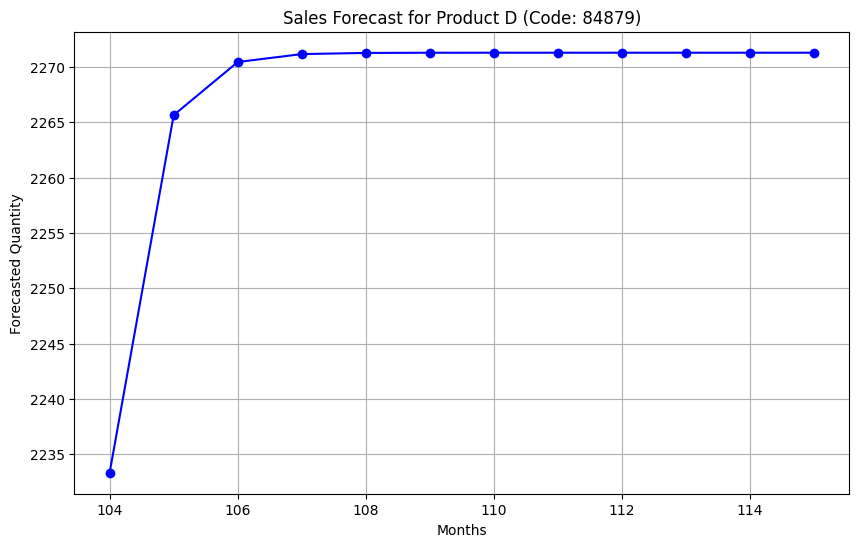

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast for Product Product E (Code: 23084) for next 12 months:
32    15907.745630
33    12660.331043
34    13356.520546
35    13207.269562
36    13239.266390
37    13232.406824
38    13233.877396
39    13233.562131
40    13233.629718
41    13233.615229
42    13233.618335
43    13233.617669
Name: predicted_mean, dtype: float64
--------------------------------------------------


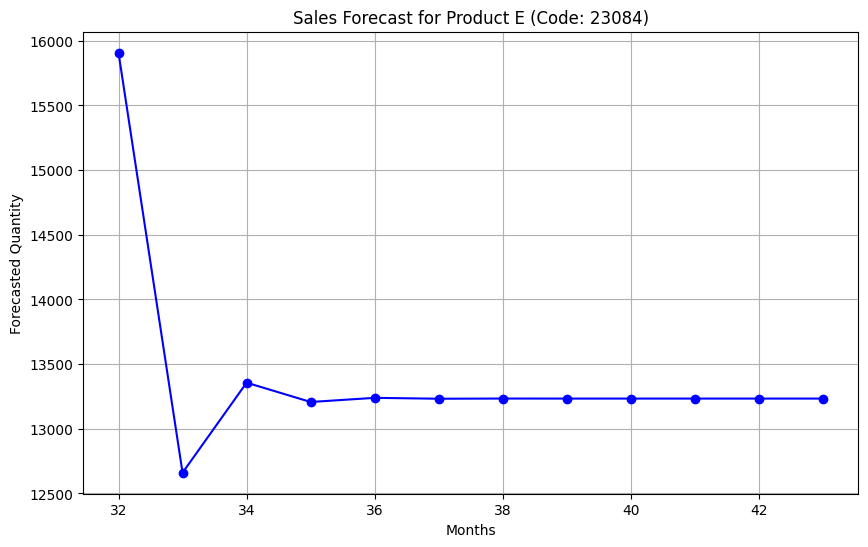

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast for Product Product F (Code: 21181) for next 12 months:
87    2200.294970
88    2221.835628
89    2223.123461
90    2223.200456
91    2223.205059
92    2223.205334
93    2223.205351
94    2223.205352
95    2223.205352
96    2223.205352
97    2223.205352
98    2223.205352
Name: predicted_mean, dtype: float64
--------------------------------------------------


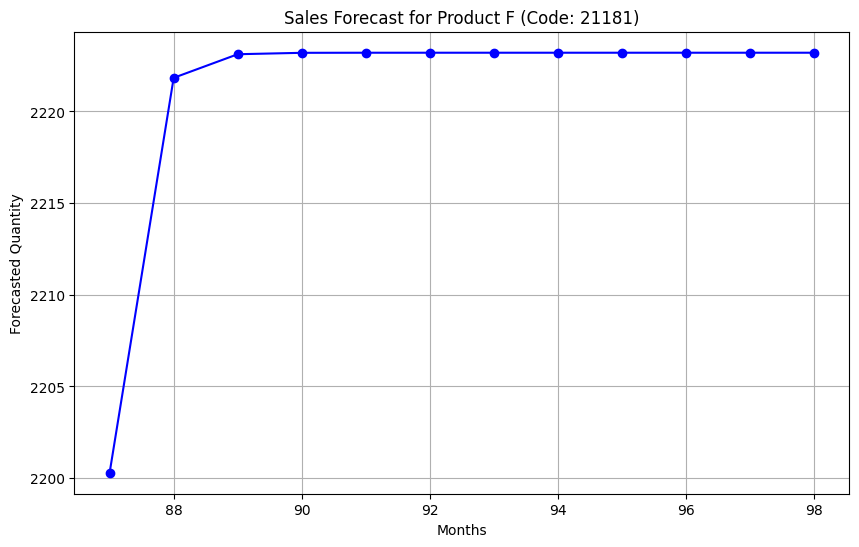

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast for Product Product G (Code: 22423) for next 12 months:
92     1711.056939
93     1786.674105
94     1781.138509
95     1781.543745
96     1781.514080
97     1781.516251
98     1781.516093
99     1781.516104
100    1781.516103
101    1781.516103
102    1781.516103
103    1781.516103
Name: predicted_mean, dtype: float64
--------------------------------------------------


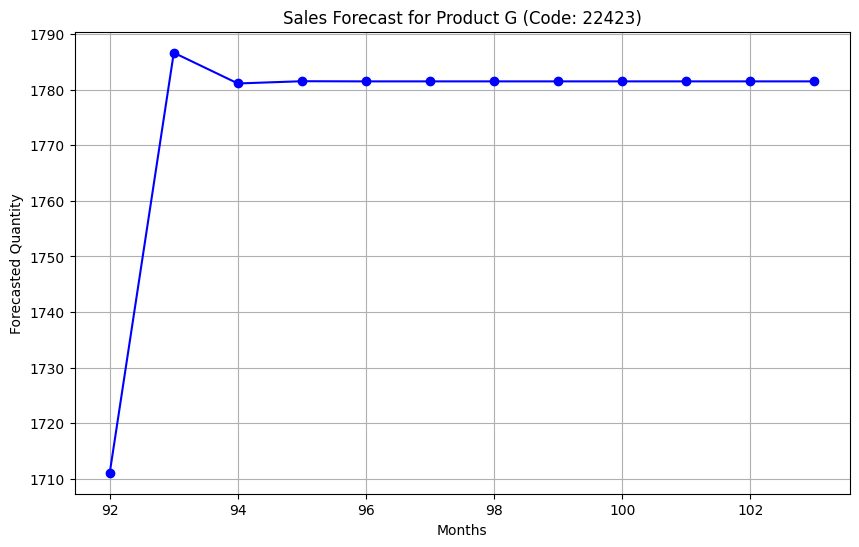

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast for Product Product H (Code: 21212) for next 12 months:
104    1020.360293
105    1247.272686
106    1221.051361
107    1224.081420
108    1223.731275
109    1223.771737
110    1223.767061
111    1223.767602
112    1223.767539
113    1223.767546
114    1223.767546
115    1223.767546
Name: predicted_mean, dtype: float64
--------------------------------------------------


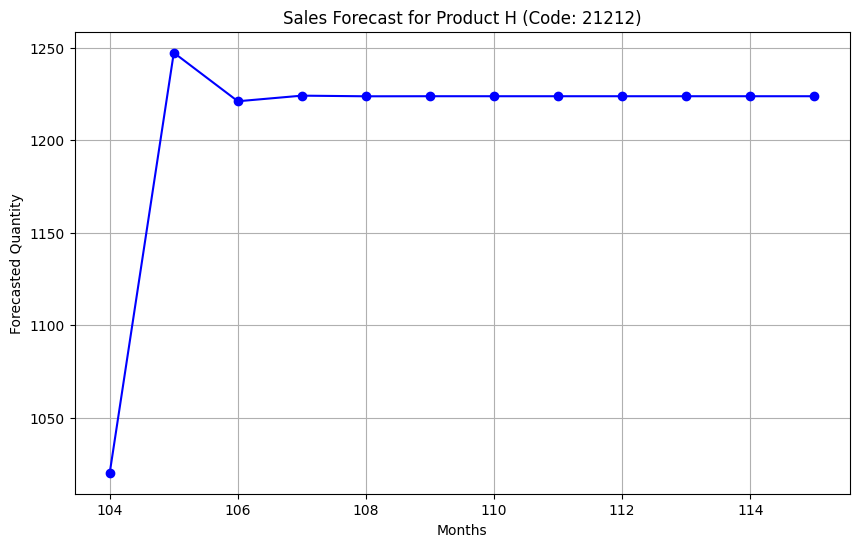

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast for Product Product I (Code: 20713) for next 12 months:
96     1616.048328
97     1788.436322
98     1812.975079
99     1816.468075
100    1816.965289
101    1817.036066
102    1817.046141
103    1817.047575
104    1817.047779
105    1817.047808
106    1817.047812
107    1817.047813
Name: predicted_mean, dtype: float64
--------------------------------------------------


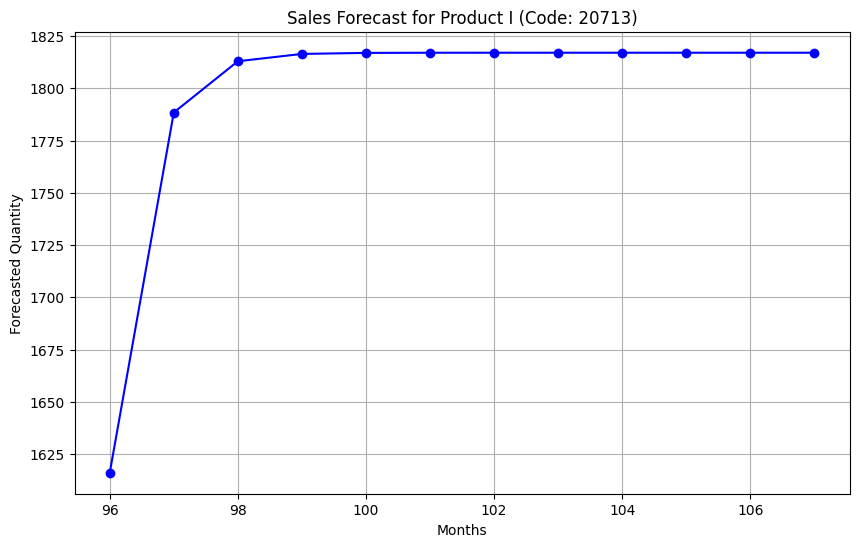

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


Forecast for Product Product J (Code: 21915) for next 12 months:
92     1113.514140
93     1046.201067
94     1056.018859
95     1054.586908
96     1054.795762
97     1054.765300
98     1054.769743
99     1054.769095
100    1054.769189
101    1054.769176
102    1054.769178
103    1054.769177
Name: predicted_mean, dtype: float64
--------------------------------------------------


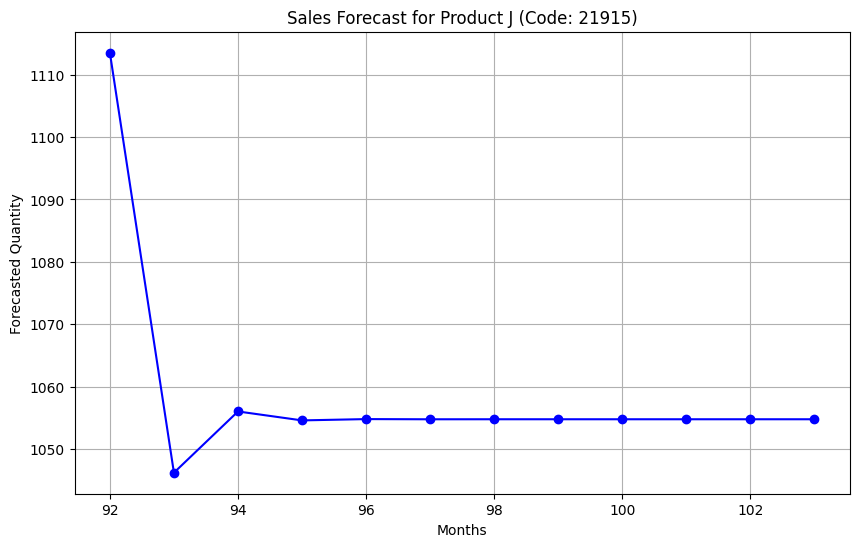

In [ ]:
# # Step 1: Mount Google Drive to access files (optional)
# from google.colab import drive
# drive.mount('/content/drive')

# # Step 2: Unzip the models folder if you have uploaded a zip file
# import zipfile
# import os

# # Assuming the uploaded file is 'models.zip'
# zip_path = '/content/models.zip'  # Update this path if necessary
# extract_path = '/content/models'

# # Extract the zip file
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# Step 3: Import necessary libraries
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from pathlib import Path

# Step 4: Create a dictionary for the top 10 products (as per your description)
top_10_products_dict = {
    '85123A': 'Product A (Code: 85123A)',
    '85099B': 'Product B (Code: 85099B)',
    '22197': 'Product C (Code: 22197)',
    '84879': 'Product D (Code: 84879)',
    '23084': 'Product E (Code: 23084)',
    '21181': 'Product F (Code: 21181)',
    '22423': 'Product G (Code: 22423)',
    '21212': 'Product H (Code: 21212)',
    '20713': 'Product I (Code: 20713)',
    '21915': 'Product J (Code: 21915)'
}

# Step 5: Define function to load and test the models
def load_and_test_models(models_folder, selected_products, n_months):
    """
    Loads ARIMA models from the specified folder and forecasts sales for the selected products.

    Parameters:
        models_folder (str): Path to the folder containing saved ARIMA models.
        selected_products (list): List of product codes to forecast.
        n_months (int): Number of months to forecast.

    Returns:
        dict: A dictionary containing forecasted sales for each product.
    """
    forecast_results = {}

    for product in selected_products:
        model_filename = Path(models_folder) / f'arima_model_product_{product}.pkl'

        if model_filename.exists():
            # Load the ARIMA model
            with open(model_filename, 'rb') as model_file:
                arima_model = pickle.load(model_file)

            # Forecast future sales
            forecast = arima_model.forecast(steps=n_months)
            forecast_results[product] = forecast

            # Print the forecast results
            print(f"Forecast for Product {top_10_products_dict[product]} for next {n_months} months:")
            print(forecast)
            print("-" * 50)

            # Plot the forecast results
            plt.figure(figsize=(10, 6))
            plt.plot(forecast, marker='o', linestyle='-', color='blue')
            plt.title(f'Sales Forecast for {top_10_products_dict[product]}')
            plt.xlabel('Months')
            plt.ylabel('Forecasted Quantity')
            plt.grid(True)
            plt.show()
        else:
            print(f"Model file for product {product} not found.")

    return forecast_results

# Step 6: Specify the path to the models folder and products to test
models_folder = '/content/models'
selected_products = list(top_10_products_dict.keys())  # Select all top 10 products or specify a subset
n_months = 12  # Change this to the desired number of months to forecast

# Step 7: Load and test models
forecast_results = load_and_test_models(models_folder, selected_products, n_months)


Arima with Lstm

In [ ]:
# Install required packages
!pip install pandas numpy matplotlib seaborn tensorflow scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima.model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import pickle
import os

# Load data
trans_data1 = pd.read_csv('Transactional_data_retail_01.csv')
trans_data2 = pd.read_csv('Transactional_data_retail_02.csv')
customer_data = pd.read_csv('CustomerDemographics.csv')
product_info = pd.read_csv('ProductInfo.csv')

# Merge transaction files
trans_data = pd.concat([trans_data1, trans_data2], ignore_index=True)

# Clean date and merge dataframes
def clean_date_format(date_str):
    try:
        return pd.to_datetime(date_str, format='%d %B %Y')
    except:
        return pd.to_datetime(date_str)

trans_data['InvoiceDate'] = trans_data['InvoiceDate'].apply(clean_date_format)
trans_data.dropna(subset=['Customer ID'], inplace=True)

merged_data = pd.merge(trans_data, customer_data, on='Customer ID', how='left')
merged_data = pd.merge(merged_data, product_info, on='StockCode', how='left')
merged_data['TotalRevenue'] = merged_data['Quantity'] * merged_data['Price']
merged_data['Year'] = merged_data['InvoiceDate'].dt.year
merged_data['Month'] = merged_data['InvoiceDate'].dt.month
merged_data['Week'] = merged_data['InvoiceDate'].dt.isocalendar().week

top_10_products = merged_data.groupby('StockCode')['Quantity'].sum().nlargest(10)
print(top_10_products)

# Filter and aggregate weekly sales for top 10 products
time_series_data = merged_data[merged_data['StockCode'].isin(top_10_products.index)]
weekly_sales = time_series_data.groupby(['StockCode', 'Year', 'Week'])['Quantity'].sum().reset_index()

# Directory to save models
models_folder = "models"
if not os.path.exists(models_folder):
    os.makedirs(models_folder)

# Define a function to preprocess data for LSTM
def preprocess_data_for_lstm(data, n_lags=4):
    X, y = [], []
    for i in range(n_lags, len(data)):
        X.append(data[i-n_lags:i])
        y.append(data[i])
    X, y = np.array(X), np.array(y)
    return X.reshape(-1, n_lags, 1), y

# Train and save ARIMA and LSTM models for each top product
for product in top_10_products.index:
    # Get the product-specific sales data
    product_sales = weekly_sales[weekly_sales['StockCode'] == product].set_index('Week')['Quantity']
    product_sales = product_sales.fillna(0)  # Fill any missing values with 0

    # Train and Save ARIMA Model
    arima_model = ARIMA(product_sales, order=(1, 1, 1))
    arima_result = arima_model.fit()
    arima_model_filename = os.path.join(models_folder, f'arima_model_product_{product}.pkl')
    with open(arima_model_filename, 'wb') as file:
        pickle.dump(arima_result, file)
    print(f"ARIMA model for Product {product} saved.")

    # Prepare data for LSTM
    X, y = preprocess_data_for_lstm(product_sales.values)

    # Split data for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define and train LSTM model
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, activation='relu', input_shape=(X_train.shape[1], 1)))
    lstm_model.add(Dense(1))
    lstm_model.compile(optimizer='adam', loss='mse')

    lstm_model.fit(X_train, y_train, epochs=50, verbose=0)

    # Save the LSTM model
    lstm_model_filename = os.path.join(models_folder, f'lstm_model_product_{product}.h5')
    lstm_model.save(lstm_model_filename)
    print(f"LSTM model for Product {product} saved.")

    # Forecast future sales using ARIMA
    arima_forecast = arima_result.forecast(steps=15)
    print(f'ARIMA Forecast for Product {product}:')
    print(arima_forecast)

    # Forecast future sales using LSTM
    lstm_predictions = lstm_model.predict(X_test[-15:])  # Get last 15 predictions
    print(f'LSTM Forecast for Product {product}:')
    print(lstm_predictions)

# Notify completion of model saving
print("ARIMA and LSTM models have been trained and saved for all top 10 products.")


<ipython-input-19-8f1578ba31f8>:30: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  return pd.to_datetime(date_str)


StockCode
85123A    450325
85099B    375064
22197     308648
84879     238302
23084     216752
21181     195192
22423     187568
21212     180498
20713     176220
21915     144868
Name: Quantity, dtype: int64
ARIMA model for Product 85123A saved.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When usin

LSTM model for Product 85123A saved.
ARIMA Forecast for Product 85123A:
104    4622.748714
105    4694.264566
106    4692.117640
107    4692.182091
108    4692.180156
109    4692.180214
110    4692.180213
111    4692.180213
112    4692.180213
113    4692.180213
114    4692.180213
115    4692.180213
116    4692.180213
117    4692.180213
118    4692.180213
Name: predicted_mean, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
LSTM Forecast for Product 85123A:
[[4543.6333]
 [5077.718 ]
 [2376.819 ]
 [3869.2466]
 [7005.1973]
 [4419.8794]
 [4961.1636]
 [3455.0537]
 [4229.5205]
 [2592.4055]
 [6364.114 ]
 [1873.3623]
 [2219.1572]
 [5152.9766]
 [5017.5864]]
ARIMA model for Product 85099B saved.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When usin

LSTM model for Product 85099B saved.
ARIMA Forecast for Product 85099B:
104    3507.118918
105    3572.180537
106    3577.177491
107    3577.561274
108    3577.590750
109    3577.593014
110    3577.593188
111    3577.593201
112    3577.593202
113    3577.593202
114    3577.593202
115    3577.593202
116    3577.593202
117    3577.593202
118    3577.593202
Name: predicted_mean, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
LSTM Forecast for Product 85099B:
[[4608.788 ]
 [2717.0684]
 [4388.569 ]
 [3085.1448]
 [4394.36  ]
 [3848.2842]
 [3040.5527]
 [3144.49  ]
 [2583.7183]
 [3561.6826]
 [3883.3567]
 [4417.6577]
 [4735.5825]
 [2846.8535]
 [3588.2268]]
ARIMA model for Product 22197 saved.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When usin

LSTM model for Product 22197 saved.
ARIMA Forecast for Product 22197:
104    4597.503289
105    4672.892853
106    4675.366663
107    4675.447838
108    4675.450501
109    4675.450589
110    4675.450591
111    4675.450592
112    4675.450592
113    4675.450592
114    4675.450592
115    4675.450592
116    4675.450592
117    4675.450592
118    4675.450592
Name: predicted_mean, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
LSTM Forecast for Product 22197:
[[2050.638  ]
 [ 785.2312 ]
 [1876.7368 ]
 [1218.7719 ]
 [ 905.45807]
 [ 720.07605]
 [2088.9487 ]
 [6672.501  ]
 [1653.1445 ]
 [3837.265  ]
 [ 514.8628 ]
 [2659.3604 ]
 [2210.2617 ]
 [ 958.0075 ]
 [1307.3381 ]]
ARIMA model for Product 84879 saved.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When usin

LSTM model for Product 84879 saved.
ARIMA Forecast for Product 84879:
104    2233.341636
105    2265.638495
106    2270.437792
107    2271.150965
108    2271.256943
109    2271.272691
110    2271.275031
111    2271.275379
112    2271.275430
113    2271.275438
114    2271.275439
115    2271.275439
116    2271.275439
117    2271.275439
118    2271.275439
Name: predicted_mean, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
LSTM Forecast for Product 84879:
[[2355.1719]
 [1451.2798]
 [1324.6637]
 [1695.3923]
 [2648.859 ]
 [1929.9122]
 [2257.648 ]
 [1391.7281]
 [1829.9807]
 [2150.9539]
 [1049.2944]
 [1554.3022]
 [1568.4103]
 [2003.8597]
 [2017.6364]]
ARIMA model for Product 23084 saved.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When usin

LSTM model for Product 23084 saved.
ARIMA Forecast for Product 23084:
32    15907.745630
33    12660.331043
34    13356.520546
35    13207.269562
36    13239.266390
37    13232.406824
38    13233.877396
39    13233.562131
40    13233.629718
41    13233.615229
42    13233.618335
43    13233.617669
44    13233.617812
45    13233.617781
46    13233.617788
Name: predicted_mean, dtype: float64


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When usin

LSTM Forecast for Product 23084:
[[ 2148.2847]
 [12421.126 ]
 [ 1752.7944]
 [  776.4327]
 [ 3897.4062]
 [ 1523.7595]]
ARIMA model for Product 21181 saved.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


LSTM model for Product 21181 saved.
ARIMA Forecast for Product 21181:
87     2200.294970
88     2221.835628
89     2223.123461
90     2223.200456
91     2223.205059
92     2223.205334
93     2223.205351
94     2223.205352
95     2223.205352
96     2223.205352
97     2223.205352
98     2223.205352
99     2223.205352
100    2223.205352
101    2223.205352
Name: predicted_mean, dtype: float64


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When usin

LSTM Forecast for Product 21181:
[[ 563.7313]
 [3917.4219]
 [1681.3667]
 [3682.944 ]
 [2533.5571]
 [2358.7112]
 [1536.2711]
 [3331.1758]
 [1333.1412]
 [2683.895 ]
 [1928.1189]
 [2367.1138]
 [1750.1552]
 [ 640.1019]
 [3149.9338]]
ARIMA model for Product 22423 saved.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


LSTM model for Product 22423 saved.
ARIMA Forecast for Product 22423:
92     1711.056939
93     1786.674105
94     1781.138509
95     1781.543745
96     1781.514080
97     1781.516251
98     1781.516093
99     1781.516104
100    1781.516103
101    1781.516103
102    1781.516103
103    1781.516103
104    1781.516103
105    1781.516103
106    1781.516103
Name: predicted_mean, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
LSTM Forecast for Product 22423:
[[1588.8182]
 [1423.8224]
 [1197.8905]
 [ 674.4066]
 [2064.9756]
 [2029.992 ]
 [1827.6244]
 [1238.0951]
 [1448.5957]
 [1738.4694]
 [1115.3491]
 [1263.0763]
 [1411.5862]
 [2990.1365]
 [1226.6636]]
ARIMA model for Product 21212 saved.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When usin

LSTM model for Product 21212 saved.
ARIMA Forecast for Product 21212:
104    1020.360293
105    1247.272686
106    1221.051361
107    1224.081420
108    1223.731275
109    1223.771737
110    1223.767061
111    1223.767602
112    1223.767539
113    1223.767546
114    1223.767546
115    1223.767546
116    1223.767546
117    1223.767546
118    1223.767546
Name: predicted_mean, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
LSTM Forecast for Product 21212:
[[1902.9116 ]
 [1904.9296 ]
 [ 886.77386]
 [2137.9355 ]
 [2195.9055 ]
 [1719.1111 ]
 [1644.9587 ]
 [ 638.83954]
 [1097.7175 ]
 [1074.02   ]
 [1682.7902 ]
 [ 952.44763]
 [ 838.6426 ]
 [1880.5535 ]
 [1537.4453 ]]
ARIMA model for Product 20713 saved.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When usin

LSTM model for Product 20713 saved.
ARIMA Forecast for Product 20713:
96     1616.048328
97     1788.436322
98     1812.975079
99     1816.468075
100    1816.965289
101    1817.036066
102    1817.046141
103    1817.047575
104    1817.047779
105    1817.047808
106    1817.047812
107    1817.047813
108    1817.047813
109    1817.047813
110    1817.047813
Name: predicted_mean, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
LSTM Forecast for Product 20713:
[[ 632.4164]
 [1274.4584]
 [3877.0354]
 [1256.9556]
 [1526.7623]
 [1878.107 ]
 [4065.9692]
 [4179.359 ]
 [1389.3489]
 [2921.292 ]
 [1788.9183]
 [1328.2744]
 [1628.1732]
 [2438.1892]
 [1410.1086]]
ARIMA model for Product 21915 saved.


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as s

LSTM model for Product 21915 saved.
ARIMA Forecast for Product 21915:
92     1113.514140
93     1046.201067
94     1056.018859
95     1054.586908
96     1054.795762
97     1054.765300
98     1054.769743
99     1054.769095
100    1054.769189
101    1054.769176
102    1054.769178
103    1054.769177
104    1054.769177
105    1054.769177
106    1054.769177
Name: predicted_mean, dtype: float64
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
LSTM Forecast for Product 21915:
[[1242.203  ]
 [ 850.49414]
 [1695.709  ]
 [ 958.63074]
 [ 641.61676]
 [1040.6362 ]
 [1206.763  ]
 [2652.917  ]
 [1889.5747 ]
 [6101.7334 ]
 [1334.0537 ]
 [1523.6416 ]
 [1047.2378 ]
 [5105.843  ]
 [ 744.65356]]
ARIMA and LSTM models have been trained and saved for all top 10 products.


In [ ]:
merged_data_filename = 'merged_data.csv'
merged_data.to_csv(merged_data_filename, index=False)

XGB and decision tree models

In [ ]:
# Install necessary packages
!pip install xgboost

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA

# Load the previously merged dataset
merged_data = pd.read_csv('merged_data.csv')  # Ensure you have this CSV saved

# Prepare weekly sales data for top 10 products
top_10_products = merged_data.groupby('StockCode')['Quantity'].sum().nlargest(10).index
weekly_sales = merged_data.groupby(['StockCode', 'Year', 'Week'])['Quantity'].sum().reset_index()

# Initialize dictionaries to store models
models = {}

# Train and save models for each top product
for product in top_10_products:
    # Get sales data for the product
    product_sales = weekly_sales[weekly_sales['StockCode'] == product]

    # Prepare features and target
    X = product_sales[['Year', 'Week']]
    y = product_sales['Quantity']

    # Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train Decision Tree model
    dt_model = DecisionTreeRegressor(random_state=42)
    dt_model.fit(X_train, y_train)

    # Save Decision Tree model
    dt_filename = f'decision_tree_model_product_{product}.pkl'
    with open(dt_filename, 'wb') as dt_file:
        pickle.dump(dt_model, dt_file)
    models[product] = {'DecisionTree': dt_model}

    # Train XGBoost model
    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
    xgb_model.fit(X_train, y_train)

    # Save XGBoost model
    xgb_filename = f'xgb_model_product_{product}.pkl'
    with open(xgb_filename, 'wb') as xgb_file:
        pickle.dump(xgb_model, xgb_file)
    models[product]['XGBoost'] = xgb_model

    # # Train ARIMA model
    # product_sales_series = product_sales.set_index(['Year', 'Week'])['Quantity']
    # arima_model = ARIMA(product_sales_series, order=(1, 1, 1))
    # arima_result = arima_model.fit()

    # # Save ARIMA model
    # arima_filename = f'arima_model_product_{product}.pkl'
    # with open(arima_filename, 'wb') as arima_file:
    #     pickle.dump(arima_result, arima_file)
    # models[product]['ARIMA'] = arima_result

    # # Forecast future sales using ARIMA
    # arima_forecast = arima_result.forecast(steps=15)
    # print(f'Forecast for Product {product}: ARIMA: {arima_forecast}')

    # Forecast using Decision Tree
    dt_forecast = dt_model.predict(X_test)
    print(f'Forecast for Product {product}: Decision Tree: {dt_forecast}')

    # Forecast using XGBoost
    xgb_forecast = xgb_model.predict(X_test)
    print(f'Forecast for Product {product}: XGBoost: {xgb_forecast}')

# Example to load models and predict for a specific product
product_to_predict = '85123A'  # Change this to your desired product code
with open(f'decision_tree_model_product_{product_to_predict}.pkl', 'rb') as dt_file:
    loaded_dt_model = pickle.load(dt_file)

with open(f'xgb_model_product_{product_to_predict}.pkl', 'rb') as xgb_file:
    loaded_xgb_model = pickle.load(xgb_file)

# Prepare input for prediction
future_data = np.array([[2023, 40]])  # Example future input
dt_prediction = loaded_dt_model.predict(future_data)
xgb_prediction = loaded_xgb_model.predict(future_data)

print(f'Decision Tree Prediction for Product {product_to_predict}: {dt_prediction}')
print(f'XGBoost Prediction for Product {product_to_predict}: {xgb_prediction}')


Forecast for Product 85123A: Decision Tree: [ 7100.  1575.  2865.  4960.  5610.  3475.  2015.  5575.  4245. 14230.
  2285.  5385.  1660.  2620.  2825.  6290.  1570.  5385.  4310.  2115.
  1820.]
Forecast for Product 85123A: XGBoost: [ 4816.844   1411.1307  2523.7026  5222.4194  5085.1045  2252.634
  4429.6597  5585.7427  4165.071  14218.719   4027.429   5472.5474
  1668.9178  1608.5441  2821.862   6411.3086  2906.3428  4220.866
  5048.43    2132.3142  1806.799 ]
Forecast for Product 85099B: Decision Tree: [5684. 5696. 1208. 2896. 7784. 7080. 1884. 2160. 1508. 6868. 1148. 5060.
    8. 4184. 2340. 5828. 5992. 2940. 2400. 2180. 1672.]
Forecast for Product 85099B: XGBoost: [6208.2373 3064.274  4324.4683 3283.125  5487.8066 5905.7017 3584.1477
 2181.3972 2183.0063 6880.643  1396.5895 5257.034  1511.869  5769.234
 2373.1643 5825.678  5743.633  3054.9497  946.4558 2174.4026 1652.1475]
Forecast for Product 22197: Decision Tree: [ 1356.   780.   940.  2480.  4460.  2464.  1876. 10100.   544.   

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
